In [2]:
import numpy as np
import lshpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import imageio
from skimage.transform import resize
from scipy import stats
import time

# LSH Definition
We hash some some vectors $p$ into buckets with $h$ coming from a hash function family $H$ $h: M \mapsto S$. The hash functions map from vector space to a bucket. We hope to be able to query $q$ approximate nearest neighbors for cosine similarity, maximum inner product, l2 distance etc. We do this by making more similar vectors collide in the same hash buckets. 

Given that:

* The approximation is defined by a factor $c > 1$.
* The distance threshold $R > 0$.

### It is guaranteed:

* If $Distance(p, q) \le R$ then $h(p) = h(q)$ with a probability $\ge P_1$. $\quad$ 
* If $Distance(p, q) \ge cR$ then $h(p) = h(q)$ with a probability $\le P_2$

## LSH for Approximate nearest neighbor
Only useful if $P_q \gt P_2$

* $K$: Bucket width: (In random projections this is the number of random projections)
* $L$: Number of hash tables. When querying the union of the collisions in all the hash tables is returned

### Guarantees:

* Preprocessing time: $\mathcal{O}(nLKt)$ ($t$ is the time of evaluating the hash function)
* Space: $\mathcal{O}(nL)$ (and the data points space)
* query time: $\mathcal{O}(LKt + dn P_2^K)$
* Succes of finding point $q$ within distance $cR$ (if it exists) w/ probability $\ge 1 - (1 - P_1^K)^L$

So given hyperparameters $P_1, P_2$ we can derive $K = \frac{\log n}{\log 1 / P_2}$

and $L = n^{\rho}$, where $\rho = \frac{\log P_1}{\log P_2}$



# L2 

$$h(x) = \lfloor \frac{ w^Tx + b}{r}  \rfloor$$

$$ P(h(x) = h(y)) =  1 - 2\Phi(-r/d) - \frac{2}{\sqrt{2 \pi} r / d } (1 - e^{r^2/ (2d^2)})$$


# Cosine similarity (Signed Random Projections)
$$ h(x) = sign(w^Tx) $$
$$ P(h(x) = h(y)) = 1 - \frac{\theta}{\pi} $$

$\theta = \cos^{-1}(\text{cosine similarity})$


In [11]:
def collision_prob_l2(r, distance):
    # https://arxiv.org/pdf/1411.3787.pdf eq. 10
    a = 1 - 2 * stats.norm.cdf(-r / distance)
    b = 2 / (np.sqrt(2 * np.pi) * r / distance) * (1 - np.exp(-r**2 / (2 * distance**2)))
    return a - b

def collision_prob_cosine(sim):
    return 1 - np.arccos(sim) / np.pi

In [12]:
collision_prob_l2(2, 1)

0.609548422215397

In [4]:
def n_hash_tables(p1, p2, n):
    return n**(np.log(p1) / np.log(p2))
    
def n_projections(p2, n):
    return np.log(n) / (np.log(1 / p2))
    
def p_query(p1, k, L):
    return (1 - (1 - p1**k)**L)


# Simhash for Cosine similarity and hamming distance

https://www.cs.princeton.edu/courses/archive/spr04/cos598B/bib/CharikarEstim.pdf

https://arxiv.org/pdf/1411.3787.pdf


In [5]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [10]:
def hash_l2(v, r, seed=1):
    np.random.seed(seed)
    w = np.random.randn(*v.shape)
    b = np.random.uniform(0., r)
    h = np.floor((w.dot(v) + b) / r)    
    return h


In [12]:
p1 = collision_prob_cosine(0.7)
print(p1)
p_query(p1, 9, 25)

0.7468166888933649


0.8466788083683645

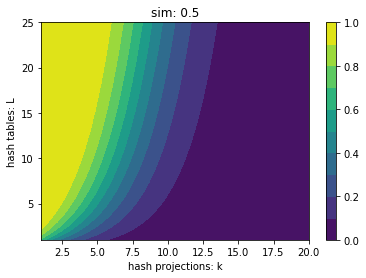

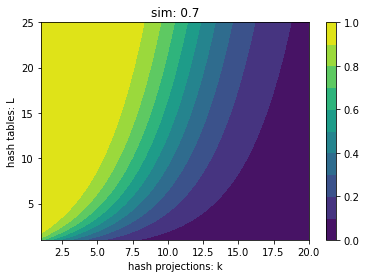

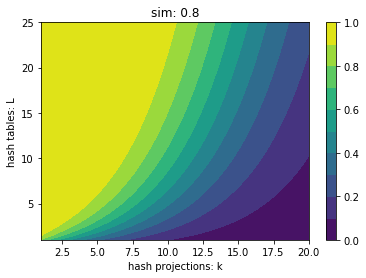

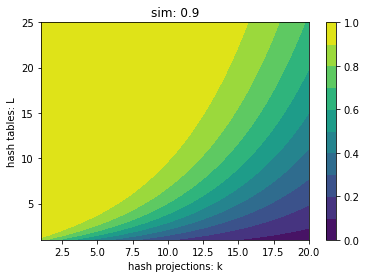

In [13]:
for sim in [0.5, 0.7, 0.8, 0.9]:
    p1 = collision_prob_cosine(sim)
    k = np.linspace(1, 20)
    L = np.linspace(1, 25)

    kk, ll = np.meshgrid(k, L)

    plt.title(f"sim: {sim}")
    plt.contourf(kk, ll, p_query(p1, kk, ll), levels=10)
    plt.xlabel("hash projections: k")
    plt.ylabel("hash tables: L")
    plt.colorbar()
    plt.show()